# MCMC from scratch

See: https://qiita.com/kenmatsu4/items/55e78cc7a5ae2756f9da

```
brew install imagemagick
brew install ffmpeg
```

In [1]:
# Load modules

import numpy as np
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation as anm
import matplotlib.cm as cm
%matplotlib inline

In [2]:
# Create a probability distribution (normal distribution) to be sampled

## mean
mean = [3.0, 1.0]

## covariance
cov = [
    [2.0, 0.5], 
    [0.5, 1.0]
]

## normal distribution definition
def normal_dist_2dim(x):
    return scipy.stats.multivariate_normal.pdf(x, mean=mean, cov=cov)

x, y = np.meshgrid(np.linspace(-5,5,100),np.linspace(-5,5,100))
xy = np.dstack((x, y))
normal_dist_2dim(xy)

array([[1.44842826e-12, 1.92738497e-12, 2.54981032e-12, ...,
        2.54981032e-12, 1.92738497e-12, 1.44842826e-12],
       [2.28509858e-12, 3.04959701e-12, 4.04620512e-12, ...,
        5.33729572e-12, 4.04620512e-12, 3.04959701e-12],
       [3.56327014e-12, 4.76927425e-12, 6.34634640e-12, ...,
        1.10425790e-11, 8.39582118e-12, 6.34634640e-12],
       ...,
       [6.15209823e-17, 1.08617594e-16, 1.90653608e-16, ...,
        8.84630694e-05, 8.87213292e-05, 8.84630694e-05],
       [3.13191122e-17, 5.54564925e-17, 9.76255023e-17, ...,
        5.97521626e-05, 6.01015537e-05, 6.01015537e-05],
       [1.57591026e-17, 2.79859770e-17, 4.94102888e-17, ...,
        3.98915683e-05, 4.02419685e-05, 4.03594512e-05]])

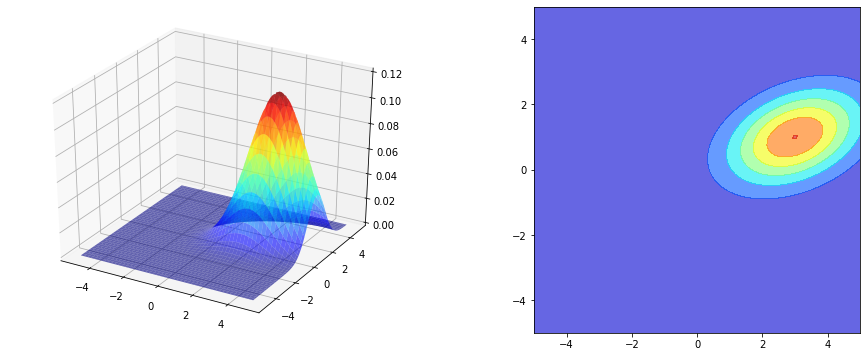

In [3]:
# Visualize above distibution

fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, normal_dist_2dim(xy), alpha=0.6, cmap='jet', shade=False)

ax2 = fig.add_subplot(122,aspect='equal')
ax2.contourf(x,y,normal_dist_2dim(xy), alpha=0.6, cmap='jet')

In [4]:
def mcmc_metroporis(x_prev, prob_dist, n_iter):
    samples = []
    
    for i in range(n_iter):
        x_next = np.array(x_prev) + np.random.normal(0, 1, len(x_prev))

        p_prev = prob_dist(x_prev)
        p_next = prob_dist(x_next)
        r = p_next / p_prev

        if r > 1.0 or r > np.random.uniform(0, 1):
            sample = (1, x_next)
            x_prev = x_next
        else:
            sample = (0, (x_prev))
        
        samples.append(sample)
        
    return samples

samples = mcmc_metroporis((0, 0), normal_dist_2dim, 1000)
samples[0:5]

[(0, (0, 0)),
 (1, array([1.76924042, 0.49027012])),
 (1, array([1.54549675, 1.45175381])),
 (1, array([1.22071769, 1.22622147])),
 (1, array([2.26852134, 1.90880425]))]

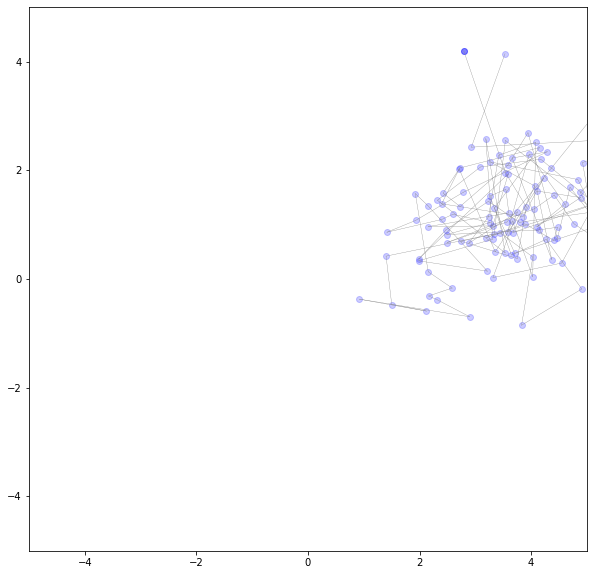

In [5]:
samples = mcmc_metroporis((4, 4), normal_dist_2dim, 200)

fig = plt.figure(figsize = (10, 10))
plt.xlim(-5, 5)
plt.ylim(-5, 5)

prev_accepted = None

def update(i, samples):
    global prev_accepted
    
    accepted, (x1, x2) = samples[i]
    if accepted == 1:
        plt.scatter(x1, x2, color='b', alpha=0.2)
        
        if prev_accepted:
            _, (x1_prev, x2_prev) = samples[prev_accepted]
            plt.plot([x1_prev, x1], [x2_prev, x2], lw=0.3, color='gray')
        prev_accepted = i
#    else:
#        plt.scatter(x1, x2, color='r', alpha=0.2)

ani = anm.FuncAnimation(fig, update, fargs=(samples, ), interval=100, frames = len(samples))

ani.save("./data/mcmc_metroporis.gif", writer = 'imagemagick')

In [6]:
# Acceptance ratio

samples_10k = mcmc_metroporis((4, 4), normal_dist_2dim, 10000)

accepted_samples = [x for accept, x in samples_10k if accept == 1]

len(accepted_samples) / len(samples_10k)

0.5844

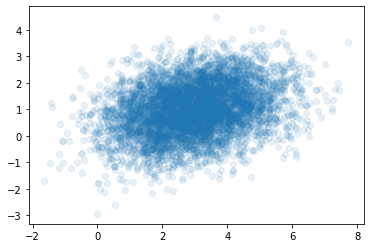

In [7]:
# Scatter plot of accepted samples

x1, x2 = np.array(accepted_samples).T

plt.scatter(x1, x2, alpha=0.1)

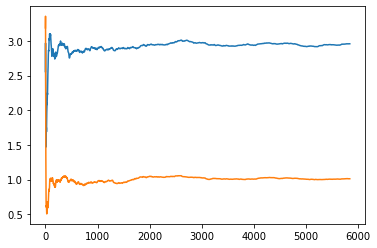

In [8]:
# Confirm conversion of mean of x1 and x2

x1_ave = [np.mean(x1[0:i]) for i in range(1, len(x1))]
x2_ave = [np.mean(x2[0:i]) for i in range(1, len(x2))]

plt.figure()
plt.plot(np.array([x1_ave, x2_ave]).T)